# Data Exploration

In this notebook, we load the KITTI dataset and explore the data.

In [116]:
# Import statements.
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from typing import Dict, Any, List, Optional, Tuple

In [50]:
# Global constants.
KITTI_ROOT_DIR = os.path.join('..', 'data', 'KITTI')
LEFT_CAM_ROOT_DIR = os.path.join(KITTI_ROOT_DIR, 'data_object_image_2')
TRAIN_IMAGE_DIR = os.path.join(LEFT_CAM_ROOT_DIR, 'training', 'image_2')
TEST_IMAGE_DIR = os.path.join(LEFT_CAM_ROOT_DIR, 'testing', 'image_2')
LABEL_DIR = os.path.join(KITTI_ROOT_DIR, 'training', 'label_2')
DEFAULT_DATASET_ARGS = {'val_split': 0.3}
TRAIN_KEY = 'train'
VAL_KEY = 'val'
TEST_KEY = 'test'

In [17]:
def get_partition(train_image_dir: str,
                  test_image_dir: str, dataset_args: Dict[str, Any] =
                  DEFAULT_DATASET_ARGS) -> Dict[str,List[str]]:
    """Returns a dict where the keys are 'train', 'test', and 'val', and the
    values are the images under each. The list is the authoratative order of the
    train/test examples; partition['train'][0] is the first training example,
    and x_train[0] will correspond with that filename.
    :param train_image_dir: The directory in which are located all the training
    images.
    :param test_image_dir: The directory in which are located all the test
    images.
    :param dataset_args: The dataset arguments. See DEFAULT_DATASET_ARGS for
    available options.
    :return: The train/val/test partition.
    """
    dataset_args = {**DEFAULT_DATASET_ARGS, **dataset_args}
    partition = {}
    train_image_filenames = [filename for
                             filename in os.listdir(train_image_dir) if
                             filename.endswith('.png')]
    rand_indices = np.random.permutation(len(train_image_filenames))
    split_index = int(dataset_args['val_split'] * len(train_image_filenames))
    val_indices = rand_indices[:split_index]
    train_indices = rand_indices[split_index:]
    partition[TRAIN_KEY] = [train_image_filenames[i] for i in train_indices]
    partition[VAL_KEY] = [train_image_filenames[i] for i in val_indices]
    test_image_filenames = [filename for
                            filename in os.listdir(test_image_dir) if
                            filename.endswith('.png')]
    partition[TEST_KEY] = test_image_filenames
    return partition

In [45]:
def load_image_into_numpy_array(
    path: str,
    target_size: Optional[Tuple[int, int]] = None) -> np.ndarray:
    """Load an image from file into a numpy array.
    :param path: The path to the image.
    :param target_size: If specified, the width and height of the output array.
    If None, the image is size is unchanged.
    :return: The image contents as an np.ndarray of type uint8.
    """
    img_data = cv2.imread(path)
    img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB)
    if target_size:
        img_data = cv2.resize(img_data, target_size)
    return img_data.astype(np.uint8)

In [96]:
def display_image(filename: str,
                  fig_size: Tuple[float, float] = (9.0, 2.75)) -> None:
    """Displays the image at filename.
    :param filename: The path to the image.
    :param fig_size: The size of the output, in inches. The default values will
    show the KITTI images in the correct aspect ratio without passing the 80
    character vertical margin in jupyter.
    """
    plt.imshow(load_image_into_numpy_array(filename))
    fig = plt.gcf()
    fig.set_size_inches(*fig_size)
    plt.tight_layout()

In [130]:
def display_image_2d_boxes(filename: str,
                           image_labels: List[str],
                           fig_size: Tuple[float, float] = (9.0, 2.75)) -> None:
    """Displays the image at filename with its 2D bounding boxes.
    :param filename: The path to the image.
    :param image_labels: The image's labels.
    :param fig_size: The size of the output, in inches.
    """
    display_image(filename, fig_size=fig_size)
    ax = plt.gca()
    for line in image_labels:
        image_class = get_label_class(line)
        x_left, y_top, x_right, y_bot = get_label_2d_box(line)
        width = x_right - x_left
        height = y_bot - y_top
        rect = patches.Rectangle((x_left, y_top), width, height, linewidth=3,
                                 edgecolor='g', facecolor='none')
        ax.add_patch(rect)

In [118]:
def get_label_class(label_line: str) -> str:
    """Returns the class from the line from a label file.
    :param label_line: A line from a label file.
    :return: The class name.
    """
    return label_line.split(' ')[0]

In [119]:
def get_label_2d_box(label_line: str) -> (float, float, float, float):
    """Returns the 2D bounding box from the line from a label file.
    :param label_line: A line from a label file.
    :return: The 2D bounding box as left, top, right, bottom.
    """
    return tuple([float(num) for num in label_line.split(' ')[4:8]])

In [104]:
def get_labels(label_dir: str) -> Dict[str, List[str]]:
    """Returns a dict where the keys are the image filenames and the values are
    the labels. Each file has several labels, each of which represents an
    object.
    :param label_dir: The directory containing the ground truth label files.
    :return: The label dict.
    """
    labels = {}
    label_filenames = [filename for filename in os.listdir(label_dir) if
                       filename.endswith('.txt')]
    for filename in label_filenames:
        with open(os.path.join(label_dir, filename), 'r') as infile:
            labels[filename.replace('.txt', '.png')] = \
                [line.strip() for line in infile.readlines()]
    return labels

In [105]:
partition = get_partition(TRAIN_IMAGE_DIR, TEST_IMAGE_DIR)
labels = get_labels(LABEL_DIR)
print('{0} train images'.format(len(partition[TRAIN_KEY])))
print('{0} val images'.format(len(partition[VAL_KEY])))
print('{0} test images'.format(len(partition[TEST_KEY])))
print('{0} labels'.format(len(labels.keys())))

5237 train images
2244 val images
7518 test images
7481 labels


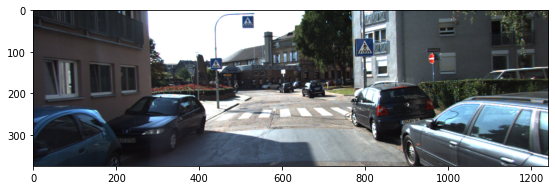

In [97]:
display_image(os.path.join(TRAIN_IMAGE_DIR, partition[TRAIN_KEY][0]))

Labels:
Car 0.00 2 -1.45 661.23 174.85 694.38 197.63 1.32 1.48 4.44 4.19 1.46 44.41 -1.35
Truck 0.00 2 2.11 125.12 91.71 474.04 253.26 4.02 2.60 16.79 -9.48 2.08 26.41 1.77
Car 0.00 0 -1.40 684.49 172.19 733.85 205.26 1.42 1.56 4.16 4.58 1.41 33.13 -1.27
Car 0.50 0 -0.72 0.00 193.56 386.20 374.00 1.45 1.59 3.44 -3.67 1.67 6.05 -1.24
Car 0.00 0 1.82 494.45 181.84 527.48 205.27 1.44 1.35 3.23 -6.41 2.04 46.74 1.68
Tram 0.00 2 1.20 587.32 158.63 648.66 188.51 3.46 2.57 14.66 0.75 1.91 90.96 1.21
DontCare -1 -1 -10 529.35 171.90 573.14 197.98 -1 -1 -1 -1000 -1000 -1000 -10
DontCare -1 -1 -10 1050.10 159.71 1073.88 173.33 -1 -1 -1 -1000 -1000 -1000 -10
DontCare -1 -1 -10 487.69 163.56 518.98 178.19 -1 -1 -1 -1000 -1000 -1000 -10
DontCare -1 -1 -10 824.36 160.32 841.17 170.97 -1 -1 -1 -1000 -1000 -1000 -10
DontCare -1 -1 -10 842.73 159.93 859.71 172.64 -1 -1 -1 -1000 -1000 -1000 -10
DontCare -1 -1 -10 888.20 158.10 921.87 174.23 -1 -1 -1 -1000 -1000 -1000 -10
DontCare -1 -1 -10 927.10 158.96

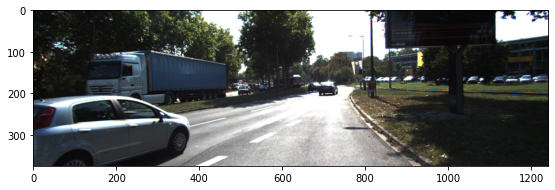

In [107]:
# Use image 0000016.png for consistency (partition is in random order).
example_filename = '000016.png'
display_image(os.path.join(TRAIN_IMAGE_DIR, example_filename))
print('Labels:')
for label in labels[example_filename]:
    print(label)

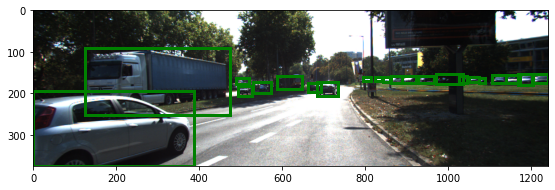

In [131]:
display_image_2d_boxes(os.path.join(TRAIN_IMAGE_DIR, example_filename),
                      labels[example_filename])